number of input columns: 81
Columns with a single value: Index([], dtype='object')
Columns with a high percentage of missing values: alley          1369
masvnrtype      872
poolqc         1453
fence          1179
miscfeature    1406
dtype: int64
Columns with a high percentage of zero values: masvnrarea        861
bsmtfinsf2       1293
2ndflrsf          829
lowqualfinsf     1434
bsmtfullbath      856
bsmthalfbath     1378
halfbath          913
wooddecksf        761
enclosedporch    1252
3ssnporch        1436
screenporch      1344
poolarea         1453
miscval          1408
dtype: int64
Columns with a high percentage of the same value: Index([], dtype='object')
Columns with a high correlation: ['1stflrsf', 'totrmsabvgrd', 'garagearea']
Columns with a low correlation: []


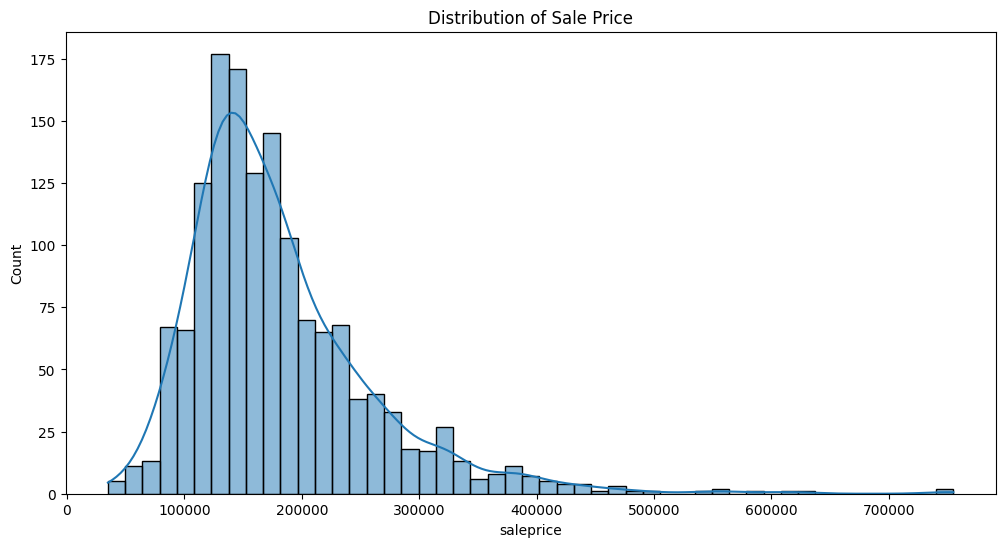

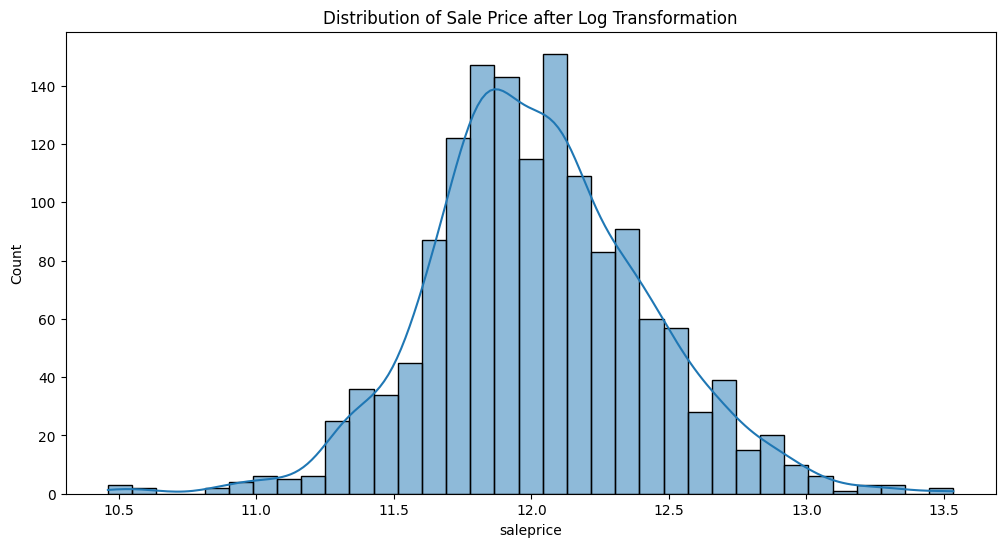

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.linear_model import LinearRegression, Lasso, Ridge  
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  
from sklearn.metrics import mean_squared_error  
from xgboost import XGBRegressor  
from lightgbm import LGBMRegressor  

# Load the dataset
df = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')

# clean column names by removing spaces and converting to lowercase
df.columns = df.columns.str.replace(' ', '_').str.lower()
print(f'''number of input columns: {len(df.columns)}''')

# do an analyis of the columns and values to determine which columns to drop or clean
# drop columns that are not useful for the model
columns_to_drop = ['id']
df = df.drop(columns=columns_to_drop)

# Drop columns with a single value
single_value_columns = df.columns[df.nunique() == 1]
print(f'''Columns with a single value: {single_value_columns}''')
df = df.drop(columns=single_value_columns)

# Drop columns with a high percentage of missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values[missing_values > 0.5 * len(df)]
print(f'''Columns with a high percentage of missing values: {missing_values}''')
df = df.drop(columns=missing_values.index)

# Drop columns with a high percentage of zero values
zero_values = (df == 0).sum()
zero_values = zero_values[zero_values > 0]
zero_values = zero_values[zero_values > 0.5 * len(df)]
print(f'''Columns with a high percentage of zero values: {zero_values}''')
df = df.drop(columns=zero_values.index)

# Drop columns with a high percentage of the same value
same_value_columns = df.columns[df.nunique() == 1]
print(f'''Columns with a high percentage of the same value: {same_value_columns}''')
df = df.drop(columns=same_value_columns)

# numerical columns and categorical columns
numerical_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(exclude=['number']).columns

# Fill missing values in numerical columns with the mean
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())
# Fill missing values in categorical columns with the mode
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

# drop high and low correlated columns
# Calculate and sort correlation matrix  
correlation_matrix = df[numerical_columns].corr().abs()  
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))  
# Identify columns with correlation greater than 0.8  
to_drop_high_correlation = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]  
print(f'''Columns with a high correlation: {to_drop_high_correlation}''')
to_drop_low_correlation = [column for column in upper_tri.columns if all(upper_tri[column] < 0.1)]
print(f'''Columns with a low correlation: {to_drop_low_correlation}''')
to_drop = list(set(to_drop_high_correlation + to_drop_low_correlation))
df = df.drop(columns=to_drop)

# Perform one-hot encoding on categorical columns using dictvectorizer
# One-hot encode categorical columns
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
df_encoded = dv.fit_transform(df[categorical_columns].T.to_dict().values())
df_encoded = pd.DataFrame(df_encoded, columns=dv.get_feature_names_out())
df = pd.concat([df, df_encoded], axis=1)
df = df.drop(columns=categorical_columns)

# save dv for later use
import joblib
joblib.dump(dv, './outputs/dv.joblib')

# check and apply long transformation on target variable if needed
# Plot the distribution of the target variable
plt.figure(figsize=(12, 6))
sns.histplot(df['saleprice'], kde=True)
plt.title('Distribution of Sale Price')
plt.show()

# Plot the distribution of the target variable after log transformation
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(df['saleprice']), kde=True)
plt.title('Distribution of Sale Price after Log Transformation')
plt.show()

# Save the log transformed target variable
df['saleprice'] = np.log1p(df['saleprice'])
df.columns = df.columns.str.replace(' ', '_').str.lower()



In [ ]:
# Assume df_* is your DataFrame with 'saleprice' as the target variable
X = df_train.drop(columns=['saleprice'])
Y = df_train['saleprice']
X_test = df_test.drop(columns=['saleprice'])
Y_test = df_test['saleprice']

# Split the dataset into training and validation datasets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

def print_best_params_and_score(model_name, grid_search):
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best CV Mean Squared Error for {model_name}: {grid_search.best_score_}")

# Function to evaluate and store results
def evaluate_model(model_name, model, params=None):
    if params:
        grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
        grid.fit(X_train, Y_train)
        best_model = grid
        print_best_params_and_score(model_name, grid)
    else:
        model.fit(X_train, Y_train)
        best_model = model

    # Evaluate on validation data
    Y_pred = best_model.predict(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    print(f"Validation Mean Squared Error ({model_name}): {mse}")
    return model_name, mse, best_model

# Dictionary to hold results
model_performance = {}

# Linear Regression
name, mse, model = evaluate_model("Linear Regression", LinearRegression())
model_performance[name] = (mse, model)

# Lasso Regression
params_lasso = {'alpha': [0.01, 0.1, 1, 10]}
name, mse, model = evaluate_model("Lasso Regression", Lasso(), params_lasso)
model_performance[name] = (mse, model)

# Ridge Regression
params_ridge = {'alpha': [0.01, 0.1, 1, 10]}
name, mse, model = evaluate_model("Ridge Regression", Ridge(), params_ridge)
model_performance[name] = (mse, model)

# Random Forest Regression
params_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
name, mse, model = evaluate_model("Random Forest", RandomForestRegressor(random_state=42), params_rf)
model_performance[name] = (mse, model)

# Gradient Boosting Regression
params_gb = {'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5], 'learning_rate': [0.01, 0.1, 0.2]}
name, mse, model = evaluate_model("Gradient Boosting", GradientBoostingRegressor(random_state=42), params_gb)
model_performance[name] = (mse, model)

# XGBoost Regression
params_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 4, 5], 'learning_rate': [0.01, 0.1, 0.2]}
name, mse, model = evaluate_model("XGBoost", XGBRegressor(random_state=42, objective='reg:squarederror'), params_xgb)
model_performance[name] = (mse, model)

# LightGBM Regression
params_lgbm = {'n_estimators': [100, 200], 'max_depth': [3, 4, 5], 'learning_rate': [0.01, 0.1, 0.2], 'verbosity': [-1]}
name, mse, model = evaluate_model("LightGBM", LGBMRegressor(random_state=42), params_lgbm)
model_performance[name] = (mse, model)

# Identify the best model based on lowest MSE
best_model_name, (best_mse, best_model) = min(model_performance.items(), key=lambda x: x[1][0])
print(f"\nThe best model is {best_model_name} with a validation MSE of {best_mse}")

# Save the best model using pickle
with open(f"./outputs/best_model_{best_model_name}.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)
print(f"The best model {best_model_name} has been saved as 'best_model_{best_model_name}.pkl'")


# Evaluate the best model on the test data
Y_test_pred_log = best_model.predict(X_test)
# Reverse transform to get predictions in the original target scale  
Y_test_pred_original = np.expm1(Y_test_pred_log)  
# Calculate the test Mean Squared Error
mse_test = mean_squared_error(Y_test, Y_test_pred_original)
print(f"Test Mean Squared Error ({best_model_name}): {mse_test}")



Validation Mean Squared Error (Linear Regression): 0.017331298663886663
Best parameters for Lasso Regression: {'alpha': 0.01}
Best CV Mean Squared Error for Lasso Regression: -0.027294941959101482
Validation Mean Squared Error (Lasso Regression): 0.023836690078065447
Best parameters for Ridge Regression: {'alpha': 10}
Best CV Mean Squared Error for Ridge Regression: -0.022440868560783107
Validation Mean Squared Error (Ridge Regression): 0.018700292889183137
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Best CV Mean Squared Error for Random Forest: -0.021218061969555207
Validation Mean Squared Error (Random Forest): 0.021208595066162416
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best CV Mean Squared Error for Gradient Boosting: -0.01757864222911374
Validation Mean Squared Error (Gradient Boosting): 0.01874067036375773
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200